In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
#sns.set_palette(palette='deep')
#sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
import numpy as np
from PIL import Image

<ipython-input-4-bcbd34fdf281>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imread('/content/drive/MyDrive//CASIA/001/nm-01/090/'+f) for f in files]


<class 'numpy.ndarray'>
(56, 150, 200)


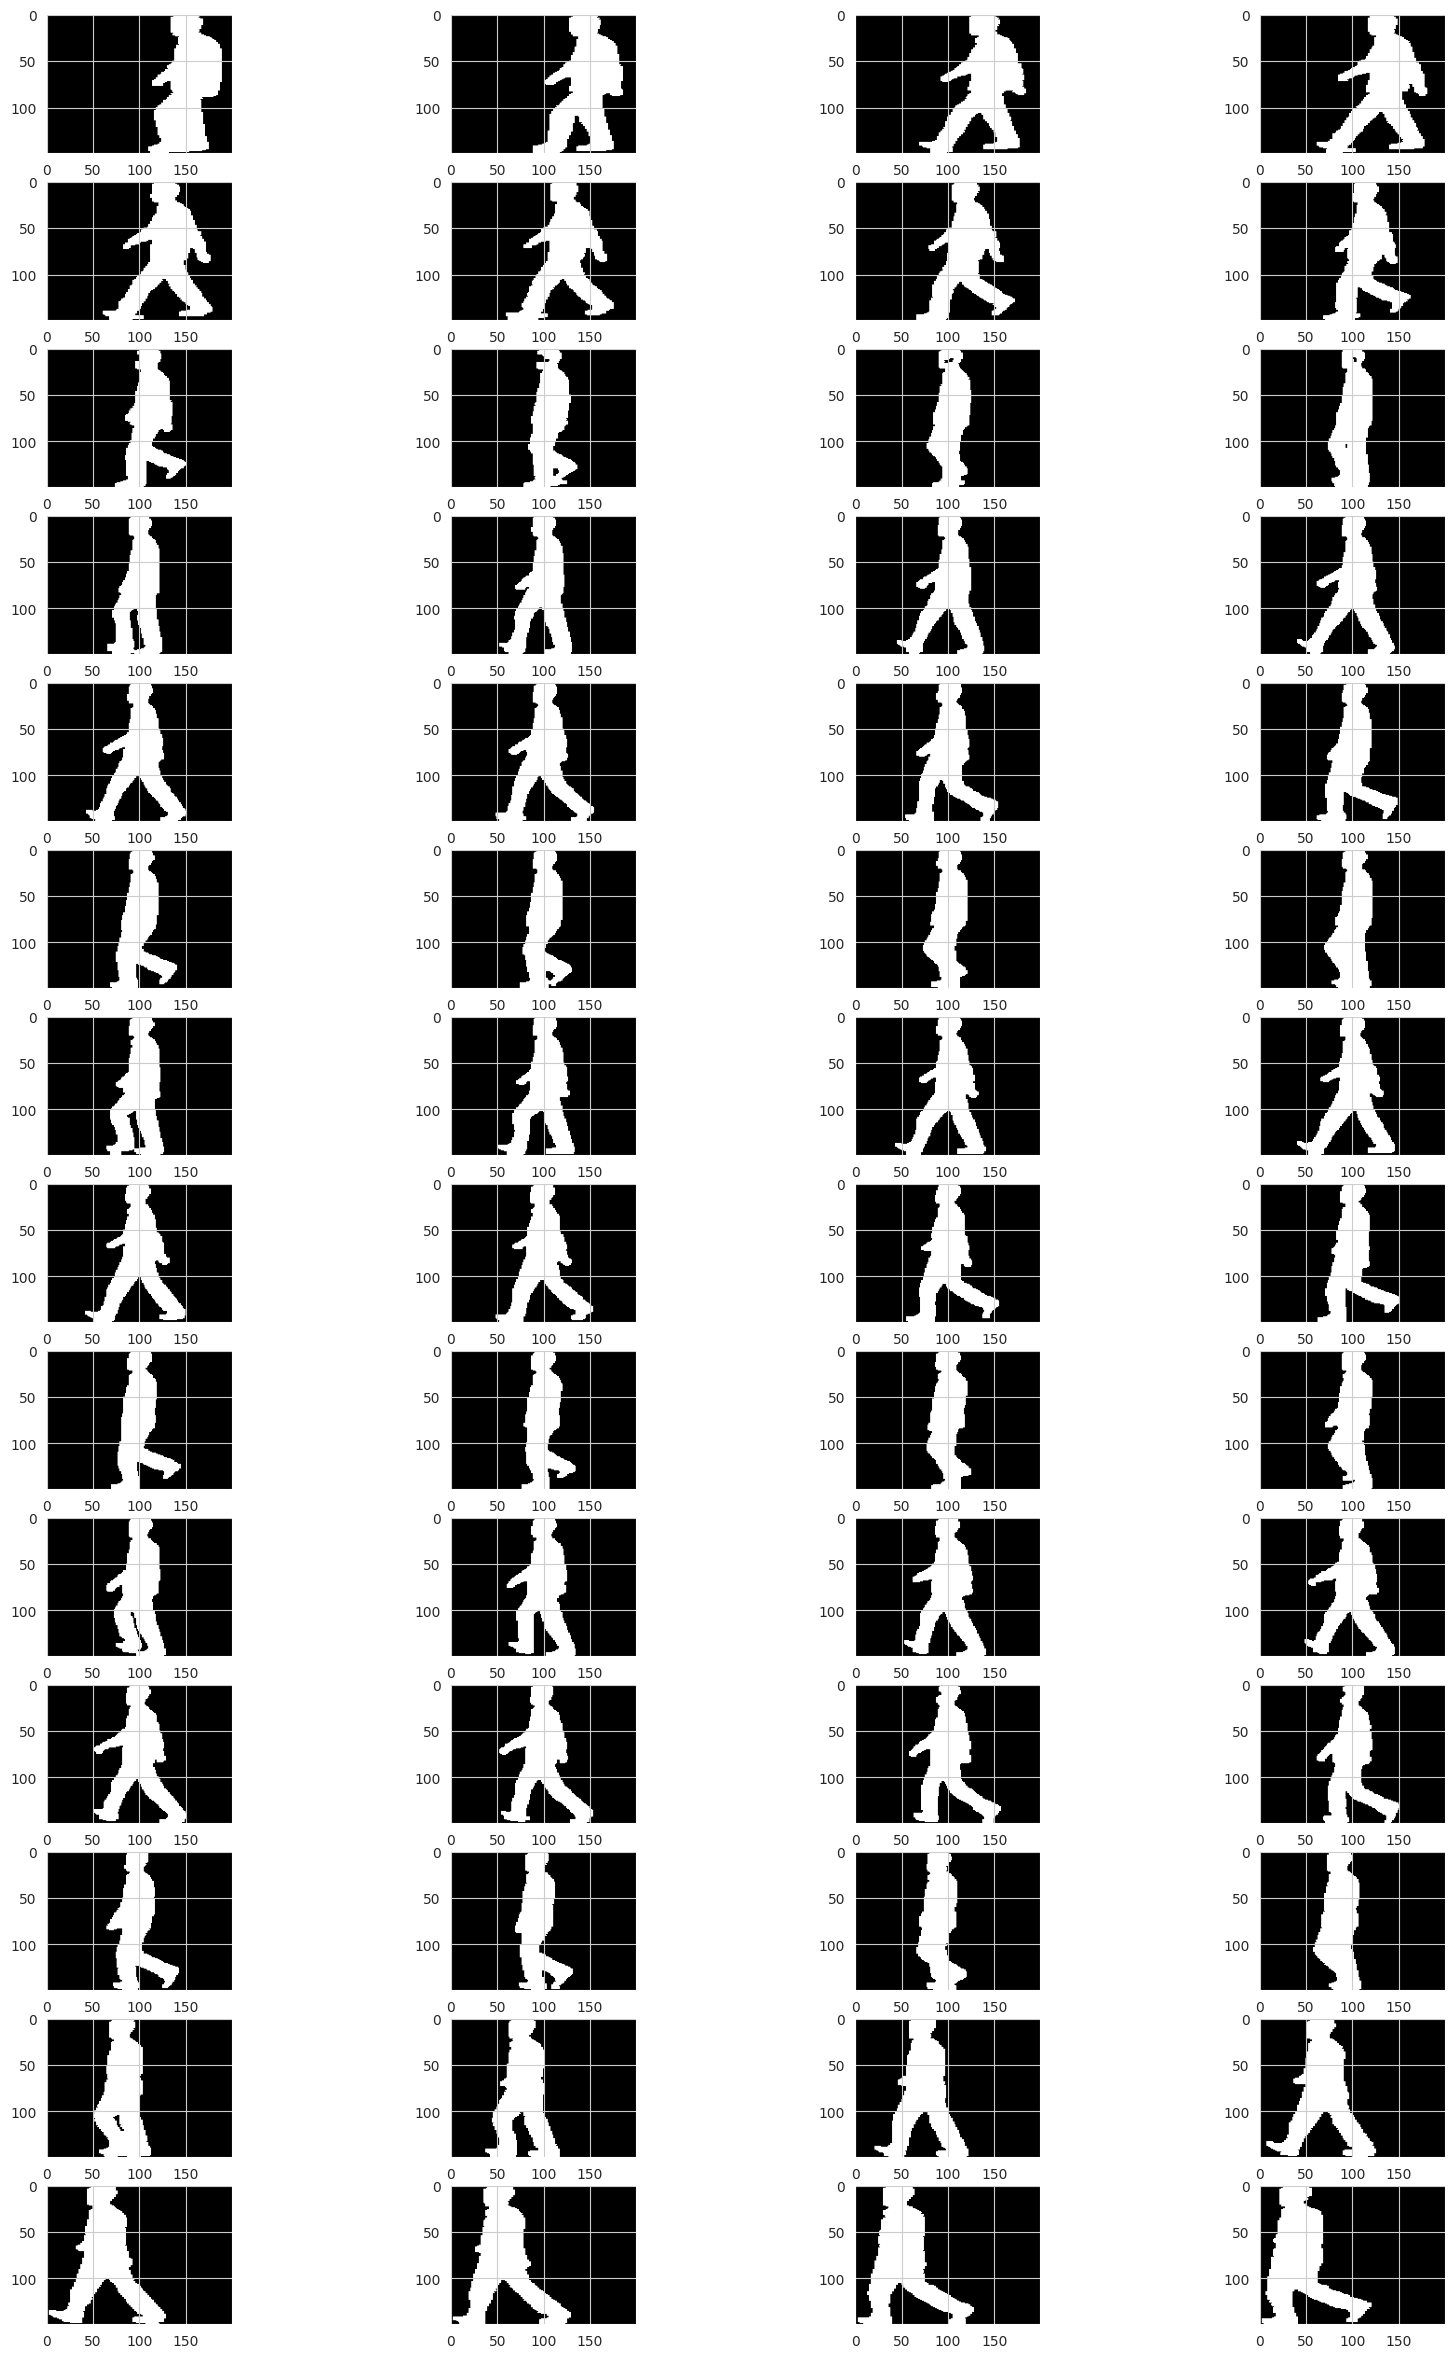

In [ ]:
# loading the gait silhouettes from the nm-01 folder
files = os.listdir('/content/drive/MyDrive/CASIA/001/nm-01/090/')
files.sort()
images = [imread('/content/drive/MyDrive//CASIA/001/nm-01/090/'+f) for f in files]

# to extract the final silhouettes with the subject at the center of the frame
def mass_center(img,is_round=True):
    Y = img.mean(axis=1)
    X = img.mean(axis=0)
    Y_ = np.sum(np.arange(Y.shape[0]) * Y)/np.sum(Y)
    X_ = np.sum(np.arange(X.shape[0]) * X)/np.sum(X)
    if is_round:
        return int(round(X_)),int(round(Y_))
    return X_,Y_

def image_extract(img,newsize):
    x_s = np.where(img.mean(axis=0)!=0)[0].min()
    x_e = np.where(img.mean(axis=0)!=0)[0].max()
    
    y_s = np.where(img.mean(axis=1)!=0)[0].min()
    y_e = np.where(img.mean(axis=1)!=0)[0].max()
    
    x_c,_ = mass_center(img)
    x_s = x_c-newsize[1]//2
    x_e = x_c+newsize[1]//2
    img = img[y_s:y_e,x_s if x_s>0 else 0:x_e if x_e<img.shape[1] else img.shape[1]]
    return np.asarray(Image.fromarray(img).resize(size=newsize).convert('L'))


images = [image_extract(i,(200,150)) for i in images]
images = np.minimum(images,1)
print(type(images))
print(images.shape)


plt.figure(figsize=(20,30))
for i in range(56):
    plt.subplot(14,4,i+1)
    plt.imshow(images[i])
    plt.imshow(images[i], cmap='Greys_r')
plt.show()

# Autoencoder

## Data for training

In [ ]:
subjects = ['001', '036', '069', '072', '078']

In [ ]:
for id in subjects[1:]:
  path = f'/content/drive/MyDrive/CASIA/{id}/nm-01/090/'
  files = os.listdir(path)
  files.sort()
  imgs = [imread(path+f) for f in files]
  imgs = [image_extract(i,(200,150)) for i in imgs]
  imgs = np.minimum(imgs,1)
  #print(type(images)) ---> numpy.ndarray
  print(imgs.shape)
  images = np.append(images, imgs, 0)

<ipython-input-6-64f66b2c75ba>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = [imread(path+f) for f in files]


(60, 150, 200)
(58, 150, 200)
(61, 150, 200)
(59, 150, 200)


In [ ]:
images.shape

(294, 150, 200)

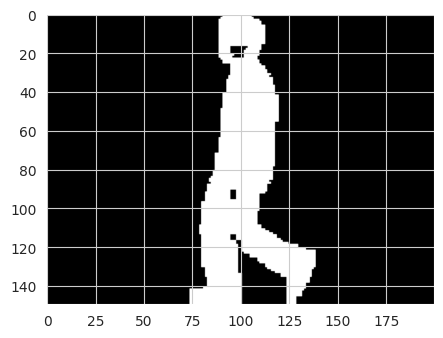

In [ ]:
plt.figure(figsize=(5, 5))

plt.subplot(1, 1, 1)
plt.imshow(images[185], cmap='Greys_r')

In [ ]:
images = np.expand_dims(images, axis=3)
images.shape

(294, 150, 200, 1)

## Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Flatten, Reshape

In [ ]:
shuffler = np.random.permutation(len(images))

images = images[shuffler]

In [ ]:
input_img = tf.keras.Input(shape=(150, 200, 1))

In [ ]:
x = None
encoded = None
decoded = None

In [ ]:
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='ae_1')(input_img)
x = MaxPooling2D((2, 2), padding='same', name='ae_2')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='ae_3')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='ae_4')(x)
print(encoded.shape)

x = UpSampling2D((2, 2), name='ae_5')(encoded)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='ae_6')(x)
x = UpSampling2D((2, 2), name='ae_7')(x)
x = Conv2D(32, (3, 3), activation='relu', name='ae_8')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='ae_9')(x)
decoded = ZeroPadding2D(padding=(0, 1), name='ae_10')(decoded)
print(decoded.shape)

(None, 38, 50, 8)
(None, 150, 200, 1)


In [ ]:
autoencoder = tf.keras.Model(input_img, decoded)

In [ ]:
autoencoder.compile(optimizer='adamax', loss='binary_crossentropy')

In [ ]:
autoencoder_history = autoencoder.fit(images, images, epochs=100, validation_split=0.1)

Epoch 1/100
9/9 [==============================] - 2s 74ms/step - loss: 0.6688 - val_loss: 0.6410
Epoch 2/100
9/9 [==============================] - 0s 38ms/step - loss: 0.6186 - val_loss: 0.5898
Epoch 3/100
9/9 [==============================] - 0s 37ms/step - loss: 0.5682 - val_loss: 0.5257
Epoch 4/100
9/9 [==============================] - 0s 38ms/step - loss: 0.4823 - val_loss: 0.4057
Epoch 5/100
9/9 [==============================] - 0s 37ms/step - loss: 0.3366 - val_loss: 0.2221
Epoch 6/100
9/9 [==============================] - 0s 38ms/step - loss: 0.1450 - val_loss: 0.0609
Epoch 7/100
9/9 [==============================] - 0s 39ms/step - loss: 0.0404 - val_loss: 0.0263
Epoch 8/100
9/9 [==============================] - 0s 37ms/step - loss: 0.0236 - val_loss: 0.0226
Epoch 9/100
9/9 [==============================] - 0s 38ms/step - loss: 0.0216 - val_loss: 0.0214
Epoch 10/100
9/9 [==============================] - 0s 38ms/step - loss: 0.0205 - val_loss: 0.0205
Epoch 11/100
9/9 [=

In [ ]:
loss = autoencoder_history.history['loss']
val_loss = autoencoder_history.history['val_loss']

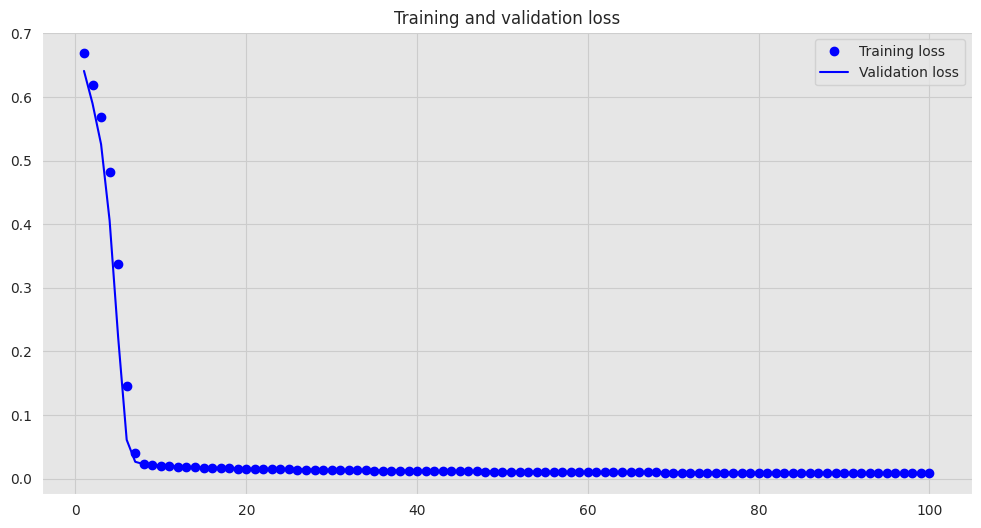

In [ ]:
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
autoencoder.save('/content/drive/MyDrive/ae_casia.h5')

### Extracting the encoder and decoder

In [ ]:
encoder = tf.keras.Model(input_img, encoded)

In [ ]:
encoder.compile(optimizer='adamax', loss='mse')

In [ ]:
encoder.load_weights("/content/drive/MyDrive/ae_casia.h5", by_name=True)

In [ ]:
input_dec = tf.keras.Input(shape=(38, 50, 8))

x2 = UpSampling2D((2, 2), name='ae_5')(input_dec)
x2 = Conv2D(8, (3, 3), activation='relu', padding='same', name='ae_6')(x2)
x2 = UpSampling2D((2, 2), name='ae_7')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', name='ae_8')(x2)
x2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='ae_9')(x2)
decoded2 = ZeroPadding2D(padding=(0, 1), name='ae_10')(x2)
print(decoded2.shape)

(None, 150, 200, 1)


In [ ]:
decoder = tf.keras.Model(input_dec, decoded2)

In [ ]:
decoder.compile(optimizer='adamax', loss='binary_crossentropy')

In [ ]:
decoder.load_weights("/content/drive/MyDrive/ae_casia.h5", by_name=True)

In [ ]:
encoder.save('/content/drive/MyDrive/enc_casia.h5')

In [ ]:
decoder.save('/content/drive/MyDrive/dec_casia.h5')